# 1) Normalize the matrix 
* Does the matrix need to be symmetric?
* Should beads get normalized in some way?
* Should we regularize the edges of the graph?

# 2) An inital guess
* Make an MDS based initial guess of the position of each bead in the array
* Could minimize a stress function? <-- look up what this is 
### Implementation
* What's a good MDS package?
  1. [Scikit-learn MDS](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html)
  * Does not work on sparse Matrices  
* How much memory is neede to run on a large matrix?
  1. If the matrix is 50K * 50K elements, a dense matrix of u16 ints will be 5GB
* Are there implementations that work on sparse matrix format?



# 3) Write a score function for a guess
* Place beads on a 2D euclidean plane
* For each bead pair observed in the data, calculate the euclidean distance between that pair of beads


In [48]:
# %pip install scikit-learn
# %pip install gitpython

import git, os, sys
import numpy as np
import scipy as sp
"""
Check if a file is downloaded. If it is not, download it.
"""
def download_file(url, filename):
    if not os.path.isfile(filename):
        print("Downloading file from", url)
        urllib.request.urlretrieve(url, filename)

def get_git_root(path):

        git_repo = git.Repo(path, search_parent_directories=True)
        git_root = git_repo.git.rev_parse("--show-toplevel")
        return git_root


In [43]:
"""
Write a function that takes as input a matrix of scores and a list of configurations and returns the best configuration.
"""
def get_best_configuration(scores, configurations):
    best_config = configurations[np.argmax(scores)]
    return best_config


In [75]:
filtered_data_matrix = sp.sparse.load_npz(get_git_root(".") + "/data/filtered_matrix.npz")

print(f'The max value in this matrix is {filtered_data_matrix.max()}')
# Compress the matrix to int16 to save space
# 32768 is the maximum value that can be stored in int16
# The max value in this matrix is 

filtered_data_matrix = filtered_data_matrix.astype(np.int16)

The max value in this matrix is 617


In [131]:
def make_random_configuration(data_matrix):
    ''''
    Place all the beads in a random configuration.
    To do this I am going to take an ideal matrix of positions and randomly assign beads to those positions.
    Initially this is just going to be a grid of positions at the moment we just want something random that we can score
    '''

    # Get the number of beads in the matrix
    num_beads = data_matrix.shape[0]
    # Use the square root of this number to make a square with this many positions
    num_positions = int(np.ceil(np.sqrt(num_beads)))
    empty_matrix = np.zeros((num_positions, num_positions))
    print(f'There are {num_beads} beads and we are placing them in a {num_positions} * {num_positions} grid')
    # Create a list of randomly sorted beads
    beads = np.arange(num_beads)
    np.random.shuffle(beads)
    # Calculate the number of empty positions
    num_empty_positions = num_positions**2 - num_beads
    # Pad the positions with zeros so that we can just reshape into a square matrix
    beads = np.pad(beads, (0, num_empty_positions), 'constant', constant_values=(0,-1))
    # Reshape the list of beads into a square matrix
    position_matrix = np.reshape(beads, (num_positions, num_positions))
    
    # Return the matrix
    return position_matrix

    

def plot_points(position_matrix):
    ''''
    Plot the positions of the beads
    '''
    import matplotlib.pyplot as plt
    # Get the positions of the beads
    positions = np.where(position_matrix != -1)
    # Generate a list of random colours
    colours = np.random.rand(len(positions[0]), 3)
    # Plot the positions with all random colours
    plt.scatter(positions[0], positions[1], c=colours, s=5)
    # Remove the axis
    plt.axis('off')
    # Remove the whitespace
    plt.tight_layout()
    # Remove the ticks 
    plt.xticks([])
    # make the plot bigger and square
    plt.gcf().set_size_inches(10,10)

    plt.box(False)


    plt.show()
    return



There are 38799 beads and we are placing them in a 197 * 197 grid


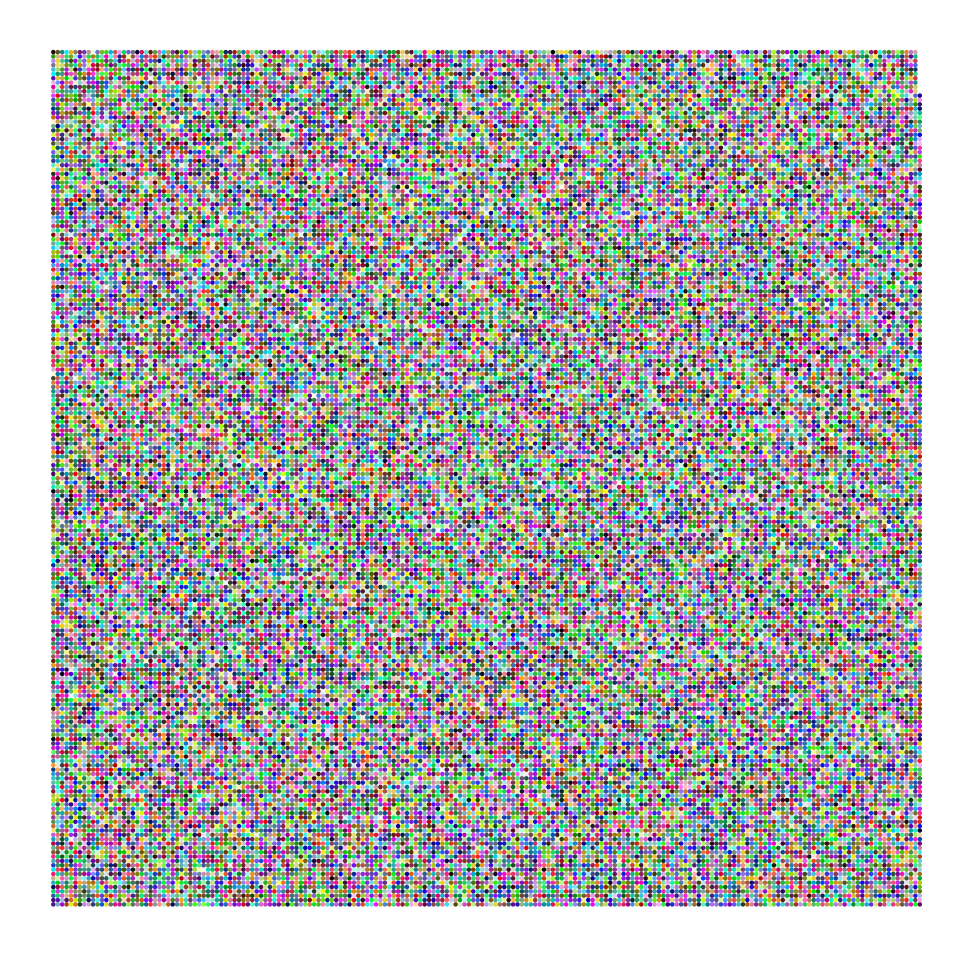

In [132]:

random_positions = make_random_configuration(filtered_data_matrix)
plot_points(random_positions)

## Make and MDS layout as an initial guess for the data

In [73]:
from sklearn import manifold

# A dense matrix of 50K * 50K * 16 bits ~ 5GB
data_dense = filtered_data_matrix.todense()
data_dense = np.asarray(data_dense)
embedding = manifold.MDS(n_components=2, normalized_stress='auto')
beads_transformed = embedding.fit_transform(data_dense)
beads_transformed.shape


/Users/sanjay/Library/Python/3.11/lib/python/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


KeyboardInterrupt: 

# 3) Score a configuration
* A given model needs to have a certain score so that it can be compared to the data.
* One idea is to take a given euclidean configuration and to use some kind of a decay function around it (that we choose). We use this decay function (e.g. a gaussian), center it on a given bead, and multiply that decay times the edge weight as it hits each bead.
 
 1) Propose a solution
 2) For each bead, center a 2D gaussian at it's center
 3) Multiply the value of this gaussian times the edge weight of every other bead.
 4) Sum these values for every bead.
 5) Calculate a gradient for each bead
 6) Move beads along this gradient by some step size corresponding to the learning rate
 
